In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data visualizaiton packages
import matplotlib.pyplot as plt
%matplotlib inline 

# Deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import datasets

In [2]:
df = pd.read_csv('/content/train.csv', dtype=np.float32)
labels = df['label'].values
img = df.drop(labels='label', axis=1).values / 255 # Normalization

# Show the shape of the dataset
print("Image shape: {}".format(img.shape))
print("Labels shape: {}".format(labels.shape))

Image shape: (42000, 784)
Labels shape: (42000,)


In [3]:
img = img.reshape(-1, 1, 28, 28)

In [4]:
img_train, img_val_test, labels_train, labels_val_test = train_test_split(img, 
                                                                          labels, 
                                                                          test_size=0.4, 
                                                                          random_state=42,
                                                                          stratify=labels)

# Split validation/test set into validation and test set
img_val, img_test, labels_val, labels_test = train_test_split(img_val_test, 
                                                              labels_val_test, 
                                                              test_size=0.5, 
                                                              random_state=42,
                                                              stratify=labels_val_test)

In [5]:
batch_size = 100
n_iters = 2000
num_epochs = n_iters / (len(img_train) / batch_size)
num_epochs = int(num_epochs)

#---------------------------------------------------------------------------------------------------------------

# Convert train set to tensors
img_train = torch.from_numpy(img_train)
labels_train = torch.from_numpy(labels_train).type(torch.LongTensor)

# Convert validation set to tensors
img_val = torch.from_numpy(img_val)
labels_val = torch.from_numpy(labels_val).type(torch.LongTensor)

# Convert test set to tensors
img_test = torch.from_numpy(img_test)
labels_test = torch.from_numpy(labels_test).type(torch.LongTensor)

#---------------------------------------------------------------------------------------------------------------

# Define Pytorch train and validation set
train = data_utils.TensorDataset(img_train, labels_train)
val = data_utils.TensorDataset(img_val, labels_val)
test = data_utils.TensorDataset(img_test, labels_test)

#---------------------------------------------------------------------------------------------------------------

# Define data loader
train_loader = data_utils.DataLoader(train, 
                                     batch_size=batch_size, 
                                     shuffle=True, num_workers=16)
valid_loader = data_utils.DataLoader(val, 
                                     batch_size=batch_size, 
                                     shuffle=True, num_workers=16)
test_loader = data_utils.DataLoader(test, 
                                    batch_size=batch_size, 
                                    shuffle=True, num_workers=16)

loaders = {'train': train_loader,
           'valid': valid_loader,
           'test': test_loader}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
num_classes = 10

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64 * 11 * 11, 2048)
        self.fc2 = nn.Linear(2048, num_classes) 
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.conv1(x)
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.pool2(F.relu(self.conv4(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 64 * 11 * 11)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate the CNN
model = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [7]:
criterion = nn.CrossEntropyLoss()

### Define optimizer
optimizer = optim.RMSprop(model.parameters(), 
                                  lr=0.001, 
                                  alpha=0.9, 
                                  eps=1e-08, 
                                  weight_decay=0.0001)

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    loss_list = []
    epoch_list = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [9]:
model = train(3, loaders, model, optimizer, 
              criterion, use_cuda, 'cnn_digit_recognizer.pt')

Epoch: 1 	Training Loss: 0.392981 	Validation Loss: 0.081456
Validation loss decreased (inf --> 0.081456).  Saving model ...
Epoch: 2 	Training Loss: 0.138027 	Validation Loss: 0.083000
Epoch: 3 	Training Loss: 0.128637 	Validation Loss: 0.069154
Validation loss decreased (0.081456 --> 0.069154).  Saving model ...


In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model, criterion, use_cuda)

Test Loss: 0.061174


Test Accuracy: 98% (8254/8400)


In [11]:
def imshow(img):
    img = img.numpy() * 255  # unnormalize and convert from Tensor image
    plt.imshow(img[0])  # show imag

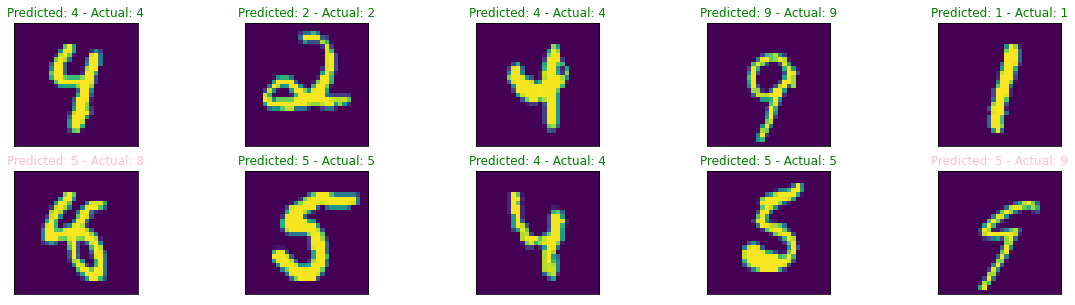

In [12]:
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("Predicted: {} - Actual: {}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "pink"))